# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
d.describe() # to get general information about the data

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [4]:
d.head(5) # to see some of the data

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

Error - 15cm according to the script.

In [28]:
%%writefile height_1_ppc.stan

generated quantities {
    real mu = normal_rng(154.6, 7.7);
    real sigma = normal_rng(15, 4);
    real height = normal_rng(mu, sigma);
}

Overwriting height_1_ppc.stan


In [29]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_1_ppc.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_1_ppc


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [30]:
sim_df = sim.draws_pd()
sim_df.head()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,175.453,18.10870,152.414
1,0.0,0.0,155.582,9.44231,157.907
2,0.0,0.0,163.830,24.06130,187.190
3,0.0,0.0,158.876,17.39580,158.493
4,0.0,0.0,164.703,13.63150,160.462


In [31]:
sim_df.describe()

,lp__,accept_stat__,mu,sigma,height
count,1000.0,1000.0,1000.000000,1000.00000,1000.000000
mean,0.0,0.0,154.895303,14.92737,155.993399
std,0.0,0.0,7.802581,4.02571,17.598161
min,0.0,0.0,132.421000,3.41009,89.027100
25%,0.0,0.0,149.642250,12.18510,145.076250
50%,0.0,0.0,154.771000,15.08835,155.876000
75%,0.0,0.0,160.283500,17.58950,165.938500
max,0.0,0.0,184.240000,28.44370,221.860000


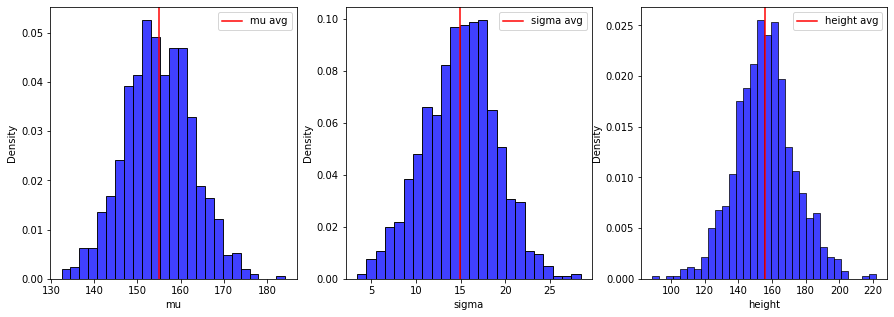

In [32]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=sim_df, stat='density', x='mu', ax=axis[0], color='b')
axis[0].axvline(x=sim_df.mu.mean(), color='r', label='mu avg')
sns.histplot(data=sim_df, stat='density', x='sigma', ax=axis[1], color='b')
axis[1].axvline(x=sim_df.sigma.mean(), color='r', label='sigma avg')
sns.histplot(data=sim_df, stat='density', x='height', ax=axis[2], color='b')
axis[2].axvline(x=sim_df.height.mean(), color='r', label='height avg')
[a.legend() for a in axis]
plt.show()

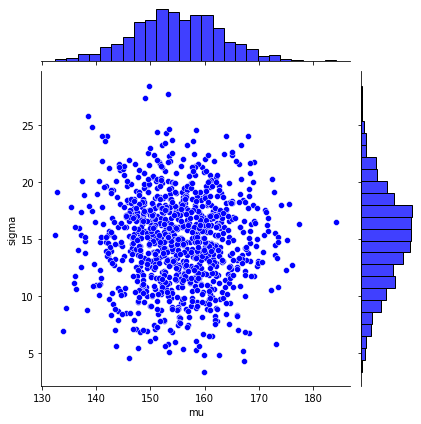

In [33]:
sns.jointplot(data=sim_df, x='mu', y='sigma', color='b')
plt.show()

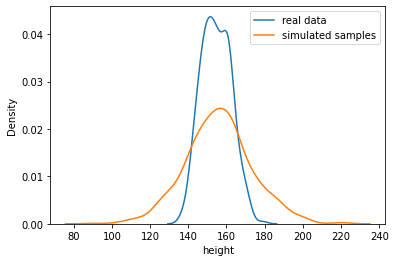

In [34]:
# to check if samples are consistent with priors, we'll use the cumulative dist. func
sns.kdeplot(data=d, x='height', label='real data')
sns.kdeplot(data=sim_df, x='height', label='simulated samples')
plt.legend()
plt.show()

Test1: (sigma = normal(15, 4)) This significantly lower and with higher deviation, but otherwise similar.  
Test2: (sigma = normal(15, 10)) This deviation for prior is too high, reverting to test 1 value (15, 4) and sticking with it.

## Task 2. Model fit and evaluation

In [35]:
%%writefile height_1_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
}

parameters {
    real<lower=0> mu;
    real<lower=0> sigma;
}

model {
    mu ~ normal(154.6, 7.7);
    sigma ~ normal(15, 4);

    heights ~ normal(mu, sigma);
}

generated quantities {
    real single_height = normal_rng(mu, sigma);
}

Writing height_1_fit.stan


In [36]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_1_fit.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_1_fit
INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_1_fit


In [37]:
# using real data as input
fit=model_1_fit.sample(data=dict(N=len(d),heights=d.height.values),seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [38]:
fit1_df = fit.draws_pd()
fit1_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,single_height
0,-890.761,0.981379,0.6653,3.0,7.0,0.0,891.344,154.513,7.57737,153.765
1,-890.806,0.708088,0.6653,2.0,3.0,0.0,892.828,154.558,8.02069,155.769
2,-890.818,0.967127,0.6653,2.0,3.0,0.0,891.367,154.639,8.02531,148.701
3,-890.579,0.990846,0.6653,3.0,7.0,0.0,891.028,154.712,7.68826,154.037
4,-890.678,0.993654,0.6653,2.0,7.0,0.0,890.720,154.470,7.94195,156.849


In [39]:
fit1_df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,single_height
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000
mean,-891.447815,0.918280,0.643815,1.975000,4.038500,0.0,892.405048,154.599967,7.809814,154.503537
std,0.938341,0.105220,0.039804,0.573112,1.958437,0.0,1.328482,0.410983,0.287956,7.764818
min,-898.785000,0.213607,0.577445,1.000000,1.000000,0.0,890.501000,153.197000,6.970310,128.159000
25%,-891.819000,0.884391,0.632655,2.000000,3.000000,0.0,891.436750,154.312000,7.609090,149.225000
50%,-891.164500,0.955833,0.658179,2.000000,3.000000,0.0,892.124000,154.597500,7.797280,154.482500
75%,-890.775000,0.994245,0.669339,2.000000,7.000000,0.0,893.025000,154.885000,7.998093,159.685250
max,-890.489000,1.000000,0.681456,3.000000,7.000000,0.0,901.605000,155.988000,8.999430,182.330000



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


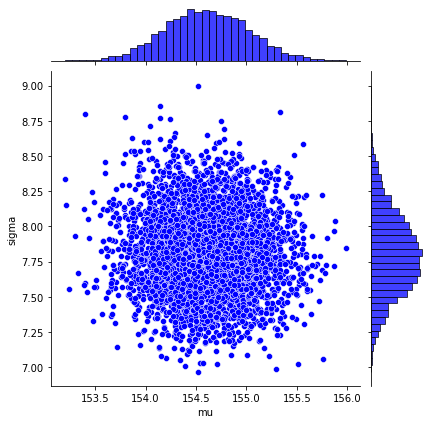

In [41]:
sns.jointplot(data=fit1_df, x='mu', y='sigma', color='b')
plt.show()

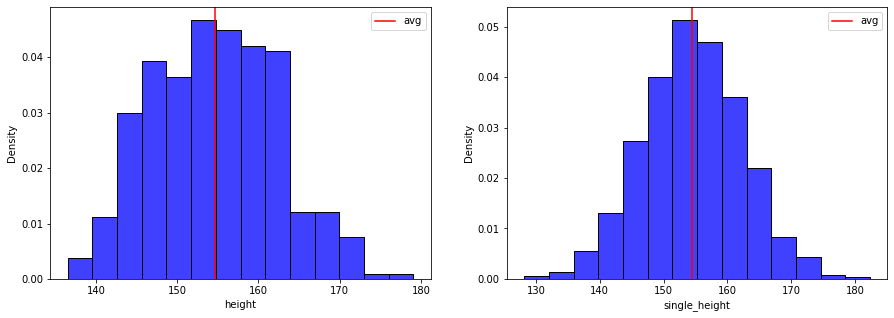

In [42]:
fig, axis = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=d, stat='density', x='height', ax=axis[0], bins=14, color='b')
axis[0].axvline(x=d.height.mean(), color='r', label='avg')
sns.histplot(data=fit1_df, stat='density', x='single_height', ax=axis[1], bins=14, color='b')
axis[1].axvline(x=fit1_df.single_height.mean(), color='r', label='avg')
[a.legend() for a in axis]
plt.show()

The model is quite comfortably comparable to real data. There is a slight difference in height distributions, as the original data is less similar to a normal distribution, it's more skewed to the lower height values, but the mean remains very close.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [43]:
d['c_weight'] = d['weight'] - d['weight'].mean()

In [44]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [45]:
%%writefile height_2a_ppc.stan
data {
    int<lower=0> N;
    vector[N] weight;
}

generated quantities {
    real alpha = normal_rng(154.6, 7.7);
    real beta = normal_rng(0, 1);
    real sigma = normal_rng(15, 4);
    vector[N] height;

    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}

Writing height_2a_ppc.stan


In [47]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [48]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,175.453,0.777181,9.91093,165.9000,151.371,168.087,178.034,189.112,...,196.411,204.054,201.157,188.982,173.210,182.081,185.228,196.001,191.765,195.823
1,0.0,0.0,145.368,-0.006780,14.98520,163.6680,156.840,156.538,163.104,163.625,...,185.342,144.916,131.788,142.923,130.993,152.989,129.657,143.760,164.798,144.109
2,0.0,0.0,151.312,-1.138640,10.11250,181.4860,164.516,164.057,171.056,168.178,...,155.175,123.345,151.310,138.665,154.326,133.882,143.102,136.839,131.153,132.973
3,0.0,0.0,147.038,-0.254452,12.96840,167.8150,141.857,147.423,137.718,147.055,...,151.193,145.792,148.698,162.061,137.583,136.904,154.531,136.578,147.884,137.835
4,0.0,0.0,146.951,1.671020,12.18900,91.8741,117.571,116.313,117.525,143.824,...,186.398,184.302,160.504,172.677,169.913,167.183,167.292,184.094,182.957,167.113


In [49]:
ppc_df.describe()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,154.748016,-0.009966,14.965146,154.911248,155.123066,154.834472,155.053408,154.588799,...,154.993115,153.580725,154.234686,153.808239,155.207069,154.745854,153.824008,155.237489,155.142393,153.752068
std,0.0,0.0,7.661223,1.003511,3.996286,22.396485,21.279537,20.727794,21.043714,21.387045,...,21.003211,21.569146,21.313309,21.775391,23.047735,23.305827,24.374037,23.870671,24.399017,25.306897
min,0.0,0.0,133.157000,-3.457130,0.994306,51.870700,75.692100,82.438900,92.013400,86.134100,...,76.532200,87.604700,95.387600,80.459100,66.728300,75.565900,71.050900,69.495800,82.248000,79.037500
25%,0.0,0.0,149.458250,-0.659877,12.475875,140.771250,141.371500,141.328000,140.549500,138.987000,...,140.779750,138.744000,139.509750,139.596250,139.890000,139.235000,137.221750,139.509000,138.714250,135.961500
50%,0.0,0.0,154.715000,-0.044096,14.823300,155.501000,155.253000,154.669000,155.087500,154.319000,...,154.045500,153.313000,154.985500,153.505500,155.233500,154.614500,153.825500,154.934000,154.979000,153.402000
75%,0.0,0.0,160.104750,0.678640,17.587475,170.113250,168.419750,169.130250,168.441750,169.722500,...,169.722500,167.761750,167.625000,167.869750,170.430500,170.531000,169.875250,171.015250,171.363000,170.870500
max,0.0,0.0,178.565000,3.898550,28.120700,218.791000,231.323000,228.283000,227.783000,222.306000,...,238.465000,237.535000,221.052000,239.715000,245.785000,228.329000,236.219000,242.763000,228.161000,225.315000


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [53]:
alphas = ppc_df['alpha'].values
betas = ppc_df['beta'].values
weights = np.linspace(d.c_weight.min(), d.c_weight.max(), R).reshape((R, 1))
heights_vs_avg_weight = weights * betas + alphas

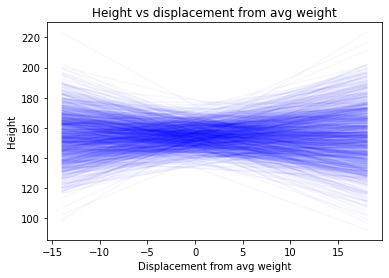

In [54]:
plt.plot(weights, heights_vs_avg_weight, 'b', alpha=0.03)
plt.title('Height vs displacement from avg weight')
plt.xlabel('Displacement from avg weight')
plt.ylabel('Height')
plt.show()

One thing that doesn't seem right is how lower weight can correlate so high with bigger height. It seems counterintuitive, as the less someone weight, the shorter they should be (on average), so the shouldn't be as many lines with low weight and big height. Applies to low height and big weight also, but now as much (intuitively, someone can be small and weigh more than a taller person with the same weight).

In [55]:
heights = ppc_df.loc[:, 'height[1]':'height[50]'].values
print(f"Heights:\n mean: [{heights.mean()}]\n std dev.: [{heights.std()}]\n min: [{heights.min()}]\n max: [{heights.max()}]")

Heights:
 mean: [154.740137552]
 std dev.: [19.7964383195821]
 min: [51.8707]
 max: [245.785]


This looks realistic. The talles human according to wikipedia is 272 cm tall (https://en.wikipedia.org/wiki/Robert_Wadlow).

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [56]:
%%writefile height_2b_ppc.stan

data {
    int<lower=0> N;
    vector[N] weight;
}

generated quantities {
    real alpha = normal_rng(154.6, 7.7);
    real beta = lognormal_rng(0, 1);
    real sigma = normal_rng(15, 4);
    vector[N] height;

    for (i in 1:N) {
        height[i] = normal_rng(alpha + beta * weight[i], sigma);
    }
}

Writing height_2b_ppc.stan


In [57]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_2b_ppc.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_2b_ppc


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_2b_ppc


In [58]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [59]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,175.453,2.175330,9.91093,146.4380,132.8200,150.4480,161.3050,173.294,...,213.383,221.937,219.951,208.687,193.826,203.608,207.665,219.349,216.024,220.992
1,0.0,0.0,145.368,0.993243,14.98520,149.7480,143.5720,143.9220,151.1390,152.312,...,197.481,157.706,145.231,157.017,145.738,168.385,145.705,160.460,182.149,162.111
2,0.0,0.0,151.312,0.320255,10.11250,161.1790,145.1600,145.6510,153.6000,151.673,...,172.884,142.005,170.921,159.225,175.837,156.343,166.514,161.201,156.466,159.236
3,0.0,0.0,147.038,0.775342,12.96840,153.4810,128.1940,134.4300,125.3970,135.404,...,163.693,158.963,162.541,176.574,152.767,152.759,171.056,153.775,165.751,156.374
4,0.0,0.0,146.951,5.317560,12.18900,41.1162,69.1884,70.3064,73.8936,102.568,...,230.663,230.943,209.521,224.069,223.681,223.326,225.811,244.988,246.227,232.759


In [60]:
ppc_df.describe()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,154.748016,1.659239,14.965146,131.676869,132.976117,133.774916,135.081262,135.704078,...,175.255546,174.930581,176.671961,177.332941,179.819188,180.445398,180.610943,183.111846,184.104153,183.801289
std,0.0,0.0,7.661223,2.480230,3.996286,39.106544,36.675368,34.762767,34.099225,33.389404,...,34.073361,36.239303,37.265056,38.830755,40.892280,41.864561,43.791902,44.568704,46.268331,47.768933
min,0.0,0.0,133.157000,0.031520,0.994306,-549.622000,-495.153000,-457.740000,-437.007000,-388.550000,...,103.381000,109.433000,113.790000,97.738300,83.930600,101.182000,108.080000,89.467200,106.780000,101.512000
25%,0.0,0.0,149.458250,0.516915,12.475875,120.067250,121.751750,122.143000,122.530500,122.492750,...,157.065000,155.509000,156.422000,158.098500,158.577000,159.079750,157.715500,160.995500,161.044750,159.474250
50%,0.0,0.0,154.715000,0.956862,14.823300,137.774500,138.693500,138.135500,139.858000,138.988000,...,169.816500,170.175000,171.723500,170.696000,172.696000,173.170000,173.682000,175.274500,176.180500,174.649000
75%,0.0,0.0,160.104750,1.971208,17.587475,151.799500,151.669500,152.529500,152.880750,154.869500,...,187.337000,185.875750,186.981250,188.443000,191.147500,192.762000,192.958000,193.539000,195.472000,196.483000
max,0.0,0.0,178.565000,49.331100,28.120700,204.591000,210.888000,208.565000,207.120000,206.994000,...,752.766000,788.966000,830.783000,855.309000,874.855000,904.688000,955.872000,969.794000,986.999000,1032.050000


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [61]:
a = ppc_df['alpha'].values
b = ppc_df['beta'].values
h = weights * b + a

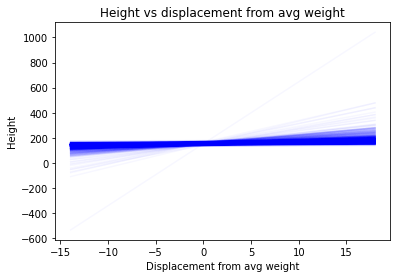

In [62]:
plt.plot(weights, h, 'b', alpha=0.03)
plt.title('Height vs displacement from avg weight')
plt.xlabel('Displacement from avg weight')
plt.ylabel('Height')
plt.show()

This is much better, as there is less options for people to weigh very little and be very tall. Also the other way around.


2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

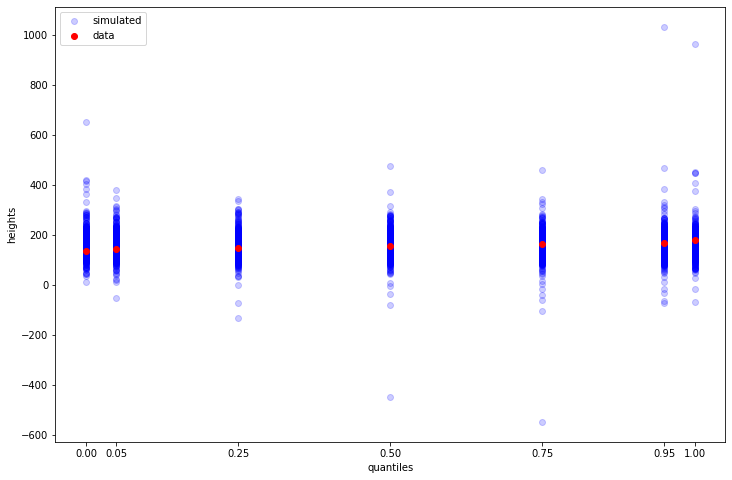

In [68]:
heights = ppc_df.loc[:, 'height[1]':'height[50]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(heights, q, axis=1)
data_quantiles = np.quantile(d.height, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.2, label='simulated', color='b')
plt.scatter(q, data_quantiles, label='data', color='r')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.legend()
plt.show()

This shows that the real data falls inside the model predictions, confirming it's realistic.

## Task 6. Fitting and evaluating model


In [69]:
%%writefile height_2_fit.stan

data {
    int<lower=0> N;
    vector[N] weights;
    vector[N] heights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta;
}

transformed parameters {
    vector[N] avg;

    for (i in 1:N) {
        avg[i] = alpha + beta * weights[i];
    }
}

model {
    alpha ~ normal(154.6, 7.7);
    sigma ~ normal(15, 4);
    beta ~ lognormal(0, 1);
    for (i in 1:N) {
        heights[i] ~ normal(avg[i], sigma);
    }
}

generated quantities {
    vector[N] height;

    for (i in 1:N) {
        height[i] = normal_rng(avg[i], sigma);
    }
}

Writing height_2_fit.stan


In [70]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_2_fit.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_2_fit


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [71]:
N = 150
data_fit = {'N':N, 'weights':d.weight.values[:N], 'heights':d.height.values[:N]}

In [72]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status











chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

















chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [73]:
df = fit.draws_pd()
df.describe() # note that the count = 4000 for later

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height[141],height[142],height[143],height[144],height[145],height[146],height[147],height[148],height[149],height[150]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-340.010936,0.925762,0.126745,3.778250,21.901500,0.0,341.488723,119.260525,5.648001,0.772322,...,152.997610,154.547844,149.337330,151.090878,154.235883,160.662887,159.607781,149.497004,154.524335,150.530379
std,1.235782,0.105903,0.012737,1.122672,12.864279,0.0,1.727051,2.918340,0.332210,0.063500,...,5.672611,5.591070,5.695706,5.800624,5.651849,5.605362,5.735418,5.638433,5.682549,5.656363
min,-347.700000,0.155066,0.109446,1.000000,1.000000,0.0,338.671000,107.874000,4.756780,0.546133,...,134.309000,136.649000,127.008000,130.811000,135.904000,140.101000,139.232000,129.488000,133.206000,131.051000
25%,-340.543000,0.898105,0.119084,3.000000,11.000000,0.0,340.231250,117.266750,5.418460,0.730719,...,149.182250,150.854000,145.621000,147.196750,150.586750,156.882250,155.757750,145.774750,150.744500,146.699500
50%,-339.686500,0.970152,0.126544,4.000000,23.000000,0.0,341.154500,119.147500,5.625275,0.774152,...,152.967000,154.475500,149.552500,151.282000,154.295500,160.628500,159.716500,149.564000,154.560000,150.558500
75%,-339.118750,0.995582,0.134205,5.000000,31.000000,0.0,342.425250,121.137500,5.863932,0.816080,...,156.807500,158.368000,153.073250,155.128500,157.953500,164.539000,163.431500,153.177500,158.386250,154.326750
max,-338.536000,1.000000,0.144447,6.000000,63.000000,0.0,352.115000,129.436000,7.014150,1.004930,...,175.577000,172.402000,173.076000,171.248000,173.809000,178.384000,188.861000,170.009000,174.659000,170.142000


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)

In [74]:
h = df.loc[:, 'height[1]':f'height[{N}]'].values

In [75]:
print(f"heights: [min: {h.min():.5f}, max: {h.max():.5f}, avg:{h.mean():.5f}]]")

heights: [min: 116.89900, max: 191.81800, avg:154.41371]]


In [76]:
a = df['alpha'].values
b = df['beta'].values

In [77]:
weights_domain = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N)
weights_domain = weights_domain.reshape((N, 1))
heights_values = b * weights_domain + a

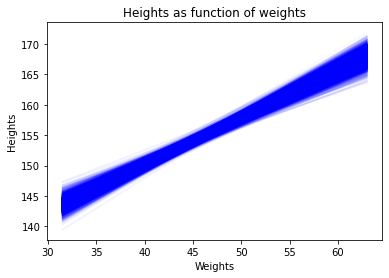

In [44]:
plt.plot(weights_domain, heights_values, 'b', alpha=0.03)
plt.title("Heights as function of weights")
plt.xlabel('Weights')
plt.ylabel('Heights')
plt.show()

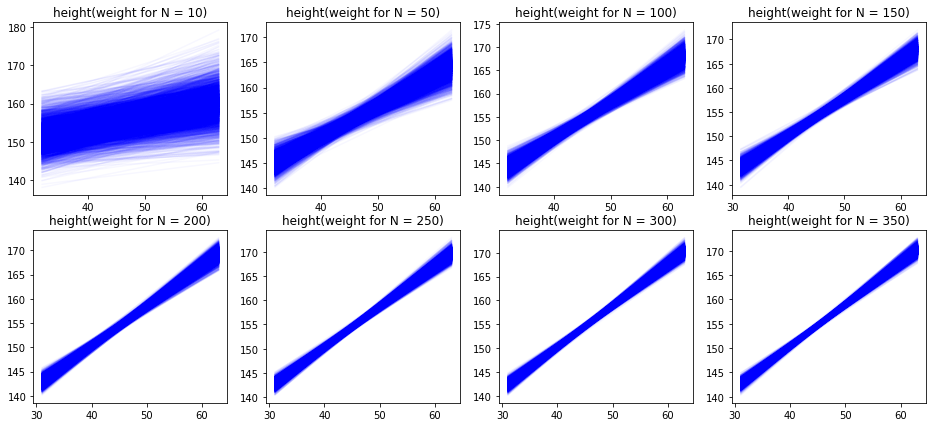

In [79]:
from logging import getLogger
cmdstanpy_logger = getLogger('cmdstanpy')
cmdstanpy_logger.disabled = True

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
axes = axes.flatten()

for i, N in enumerate([10, 50, 100, 150, 200, 250, 300, 350]):
    data_fit = {'N':N, 'weights':d.weight.values[:N], 'heights':d.height.values[:N]}
    fit = model_2_fit.sample(data=data_fit, seed=28052020, show_progress=False)
    df = fit.draws_pd()
    a = df['alpha'].values
    b = df['beta'].values

    weights_domain = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N)
    weights_domain = weights_domain.reshape((N, 1))
    heights_values = b * weights_domain + a

    axes[i].plot(weights_domain, heights_values, 'b', alpha=0.03)
    axes[i].set_title(f"height(weight for N = {N})")
plt.show()

cmdstanpy_logger.disabled = False

The more samples we get, the tighter the model fits.

3. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [80]:
N = 100
data_fit = {'N':N, 'weights':d.weight.values[:N], 'heights':d.height.values[:N]}
fit = model_2_fit.sample(data=data_fit, seed=28052020, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing


INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


In [81]:
df = fit.draws_pd()
df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height[91],height[92],height[93],height[94],height[95],height[96],height[97],height[98],height[99],height[100]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-231.002889,0.926501,0.121668,3.793750,22.258500,0.0,232.519616,119.726736,5.824190,0.767368,...,160.971054,159.679569,152.276416,157.843788,151.789636,162.781011,152.050663,160.264893,158.397874,152.323560
std,1.261293,0.105926,0.008833,1.140191,13.495803,0.0,1.762406,3.756553,0.461709,0.082040,...,5.923300,5.931454,5.884949,5.885397,5.855679,5.959694,5.919178,5.875755,5.946738,5.857933
min,-237.544000,0.153620,0.114112,1.000000,1.000000,0.0,229.554000,107.481000,4.483300,0.498131,...,140.928000,135.443000,131.837000,138.451000,132.121000,140.537000,127.371000,141.095000,136.993000,129.385000
25%,-231.647000,0.901010,0.116757,3.000000,11.000000,0.0,231.187000,117.131000,5.495620,0.713294,...,157.030250,155.673750,148.372000,153.781500,147.830500,158.946000,148.191750,156.202500,154.449250,148.413750
50%,-230.705000,0.971000,0.117919,4.000000,23.000000,0.0,232.215000,119.675500,5.795410,0.769087,...,160.984000,159.830500,152.342000,157.755500,151.772000,162.735000,152.139000,160.172500,158.403500,152.344500
75%,-230.043000,0.995118,0.122830,5.000000,31.000000,0.0,233.507500,122.243750,6.110923,0.823761,...,164.985250,163.784500,156.259500,161.820500,155.769000,166.841500,155.989500,164.368000,162.427000,156.312500
max,-229.411000,1.000000,0.136723,6.000000,63.000000,0.0,241.399000,132.902000,7.807030,1.030880,...,182.258000,180.305000,176.627000,182.828000,172.432000,186.577000,173.984000,181.495000,182.780000,178.691000


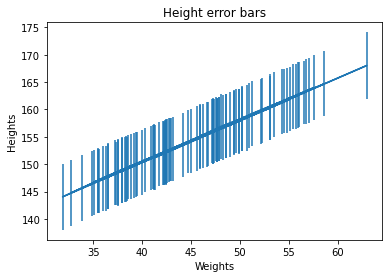

In [82]:
heights = df.loc[:, 'height[1]':f'height[{N}]'].values
weights = data_fit['weights']
y = heights.mean(axis=0)
x = weights
y_err = heights.std(axis=0)

plt.errorbar(x, y, y_err)
plt.title('Height error bars')
plt.xlabel('Weights')
plt.ylabel('Heights')
plt.show()

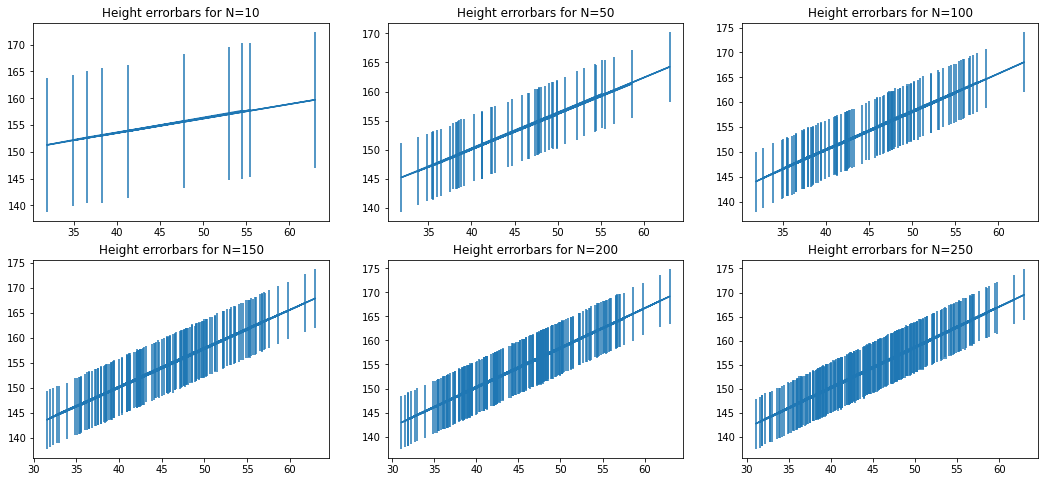

In [83]:
cmdstanpy_logger.disabled = True

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, N in enumerate([10, 50, 100, 150, 200, 250]):
    data_fit = {'N':N, 'weights':d.weight.values[:N], 'heights':d.height.values[:N]}
    fit = model_2_fit.sample(data=data_fit, seed=28052020, show_progress=False)
    df = fit.draws_pd()
    heights = df.loc[:, 'height[1]':f'height[{N}]'].values
    weights = data_fit['weights']
    y = heights.mean(axis=0)
    x = weights
    y_err = heights.std(axis=0)

    axes[i].errorbar(x, y, y_err)
    axes[i].set_title(f'Height errorbars for N={N}')
plt.show()

cmdstanpy_logger.disabled = False

The errorbars become smaller with more samples

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing


INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


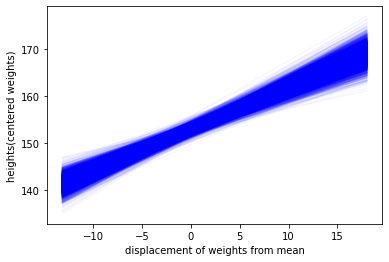

In [85]:
N = 50
data_fit = {'N':N, 'weights':d.c_weight.values[:N], 'heights':d.height.values[:N]} # c_weight already exists in the dataframe
fit = model_2_fit.sample(data=data_fit, seed=28052020, show_progress=False)

df = fit.draws_pd()
a = df['alpha'].values
b = df['beta'].values
weights_domain = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N)
weights_domain = weights_domain.reshape((N, 1))
heights_values = b * weights_domain + a

plt.plot(weights_domain, heights_values, 'b', alpha=0.03)
plt.xlabel('displacement of weights from mean')
plt.ylabel('heights(centered weights)')
plt.show()

The model still seems to be fitting, at least the heights seem to not have changed a lot. Arguably, it's an even tighter fit.


2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.


In [132]:
%%writefile height_3_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
    vector[N] weights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta1;
    real<lower=0> beta2;
}

transformed parameters {
    vector[N] avg;

    for (i in 1:N) {
        avg[i] = alpha + beta1 * weights[i] + beta2 * weights[i] * weights[i];
    }
}

model {
    alpha ~ normal(154.6, 7.7);
    sigma ~ normal(15, 4);
    beta1 ~ lognormal(0, 1);
    beta2 ~ lognormal(0, 1);

    for (i in 1:N) {
        heights[i] ~ normal(avg[i], sigma);
    }
}

generated quantities {
    vector[N] height;

    for (i in 1:N) {
        height[i] = normal_rng(avg[i], sigma);
    }
}

Overwriting height_3_fit.stan


In [133]:
model_3_fit = CmdStanModel(stan_file='height_3_fit.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_3_fit.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_3_fit


INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_3_fit


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


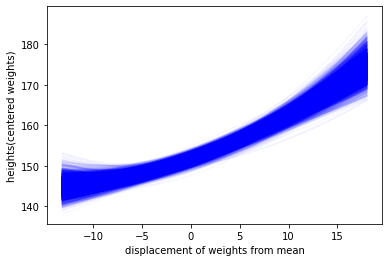

In [134]:
N = 50
data_fit = {'N':N, 'weights':d.c_weight.values[:N], 'heights':d.height.values[:N]}
fit = model_3_fit.sample(data=data_fit, seed=28052020, show_progress=False)

df = fit.draws_pd()
a = df['alpha'].values
b1 = df['beta1'].values
b2 = df['beta2'].values
weights_domain = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N)
weights_domain = weights_domain.reshape((N, 1))
heights_values = b1 * weights_domain + b2 * weights_domain**2 + a

plt.plot(weights_domain, heights_values, 'b', alpha=0.03)
plt.xlabel('displacement of weights from mean')
plt.ylabel('heights(centered weights)')
plt.show()

3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [135]:
%%writefile height_3_vectorized_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
    vector[N] weights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta1;
    real<lower=0> beta2;
}

transformed parameters {
    vector[N] avg;
    avg = alpha + beta1 * weights + beta2 * square(weights);
}

model {
    alpha ~ normal(154.6, 7.7);
    sigma ~ normal(15, 4);
    beta1 ~ lognormal(0, 1);
    beta2 ~ lognormal(0, 1);

    heights ~ normal(avg, sigma);

}

generated quantities {
    vector[N] height;
    
    for (i in 1:N) {
        height[i] = normal_rng(avg[i], sigma);
    }
    
}

Writing height_3_vectorized_fit.stan


In [136]:
model_3_fit_vectorized=CmdStanModel(stan_file='height_3_vectorized_fit.stan')

INFO:cmdstanpy:compiling stan file /home/labs/DataAnalytics2023/Lab4/height_3_vectorized_fit.stan to exe file /home/labs/DataAnalytics2023/Lab4/height_3_vectorized_fit
INFO:cmdstanpy:compiled model executable: /home/labs/DataAnalytics2023/Lab4/height_3_vectorized_fit


In [137]:
N = 50
data_fit = {'N': N, 'weights': d.c_weight.values[:N], 'heights': d.height.values[:N]}
fit=model_3_fit_vectorized.sample(data=data_fit, seed=28052020)
df = fit.draws_pd()
df.describe()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 4 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta1,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-112.869549,0.924982,0.526821,2.620750,6.327500,0.0,114.847786,151.655412,5.475271,0.837651,...,151.388358,167.488900,153.151019,151.093670,157.458560,161.657167,152.386806,154.300057,159.020869,153.995815
std,1.455311,0.093742,0.035481,0.504463,1.969699,0.0,1.997489,0.888631,0.620106,0.109484,...,5.718931,5.781617,5.693316,5.597803,5.613063,5.762547,5.701913,5.665695,5.678235,5.648074
min,-121.943000,0.163052,0.499412,1.000000,1.000000,0.0,111.071000,148.558000,3.757020,0.427364,...,134.261000,144.592000,129.974000,125.944000,134.670000,139.327000,131.213000,131.090000,138.049000,132.132000
25%,-113.542000,0.893530,0.505264,2.000000,7.000000,0.0,113.393750,151.066000,5.030147,0.765992,...,147.653000,163.656750,149.463250,147.279750,153.703500,157.756000,148.626500,150.514250,155.232750,150.217500
50%,-112.533000,0.959029,0.510085,3.000000,7.000000,0.0,114.523500,151.665000,5.432685,0.836284,...,151.433500,167.440500,153.197500,151.195000,157.361500,161.729500,152.426000,154.418000,158.908000,153.895000
75%,-111.804000,0.989462,0.531642,3.000000,7.000000,0.0,115.965500,152.248000,5.839070,0.911892,...,155.202750,171.279750,156.915000,154.834000,161.270250,165.530500,156.215250,158.084000,162.844500,157.751750
max,-110.820000,1.000000,0.587701,4.000000,15.000000,0.0,125.400000,154.882000,8.292210,1.224410,...,178.389000,193.087000,171.775000,177.768000,177.194000,184.735000,174.313000,175.335000,180.864000,177.137000


In [139]:
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta1,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,-111.488,0.976130,0.499412,2.0,7.0,0.0,116.203,152.466,5.46113,0.805678,...,143.557,167.094,152.025,150.645,158.106,161.306,151.020,149.096,160.578,145.128
1,-114.768,0.948393,0.499412,3.0,7.0,0.0,114.955,151.888,4.78838,1.093040,...,150.420,170.410,154.119,146.154,149.198,162.698,153.743,156.681,167.300,159.333
2,-114.263,1.000000,0.499412,3.0,7.0,0.0,116.436,150.945,6.23202,0.591059,...,135.276,166.745,144.282,137.479,138.251,150.588,144.304,155.111,158.642,155.420
3,-113.481,0.978318,0.499412,3.0,7.0,0.0,115.535,151.348,4.82044,1.045360,...,157.421,173.062,154.557,147.481,156.573,166.761,144.235,151.861,162.575,154.073
4,-111.149,1.000000,0.499412,3.0,7.0,0.0,114.083,151.037,5.49323,0.808007,...,157.774,170.433,145.429,159.386,160.687,159.654,151.973,149.717,148.157,147.915


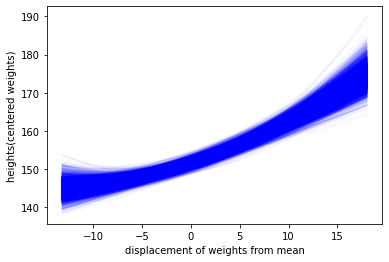

In [140]:
a = df['alpha'].values
b1 = df['beta1'].values
b2 = df['beta2'].values
weights_domain = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N)
weights_domain = weights_domain.reshape((N, 1))
heights_values = b1 * weights_domain + b2 * weights_domain**2 + a

plt.plot(weights_domain, heights_values, 'b', alpha=0.03)
plt.xlabel('displacement of weights from mean')
plt.ylabel('heights(centered weights)')
plt.show()

This model still fits well. It seems the characteristic has changed, but that's expected if the function is quadratic. This kind of model may fit the tightest from the ones defined in this excercise.